In [22]:
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from scipy.stats import ttest_ind
matplotlib.style.use('ggplot')

%matplotlib inline

In [5]:
test = pd.read_csv('dataset/Translation_Test/test_table.csv', parse_dates=['date'])
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [6]:
user = pd.read_csv('dataset/Translation_Test/user_table.csv')
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
user_id             453321 non-null int64
date                453321 non-null datetime64[ns]
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 31.1+ MB


In [8]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
user_id    452867 non-null int64
sex        452867 non-null object
age        452867 non-null int64
country    452867 non-null object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


It looks like there are some missing value in the user table.

In [9]:
print("Test:\t",len(test['user_id'].unique()), len(test['user_id'].unique()) == len(test))
print("User:\t",len(user['user_id'].unique()), len(user['user_id'].unique()) == len(user))

Test:	 453321 True
User:	 452867 True


In [72]:
data = pd.merge(left=test, right=user, how='left', on='user_id' )
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [78]:
data.columns

Index(['user_id', 'date', 'source', 'device', 'browser_language',
       'ads_channel', 'browser', 'conversion', 'test', 'sex', 'age',
       'country'],
      dtype='object')

## 1. Confirm that the test is actually negative.

First, we need to prove that in the control group, spain performs better.

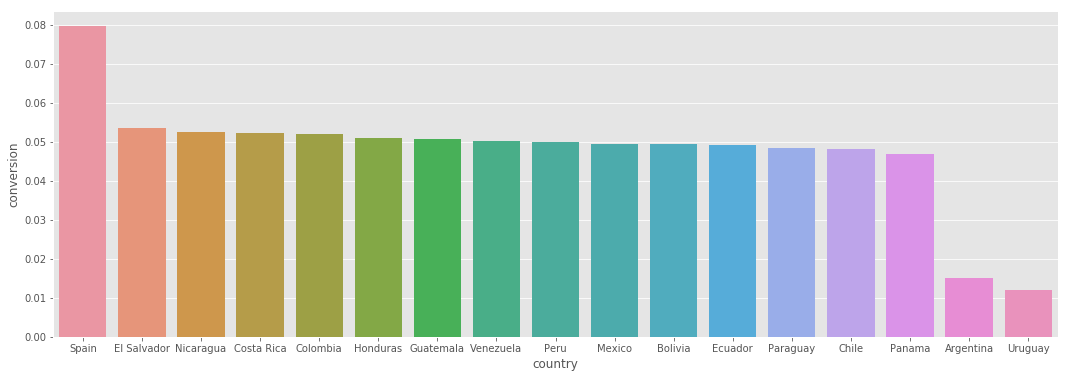

In [23]:
groupby_country = data[data['test'] == 0][['conversion', 'country']].groupby('country').mean()
groupby_country = groupby_country.reset_index()
groupby_country = groupby_country.sort_values('conversion', ascending = False )

# Visualization
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='country', y='conversion', data=groupby_country, ax=ax)
plt.show()

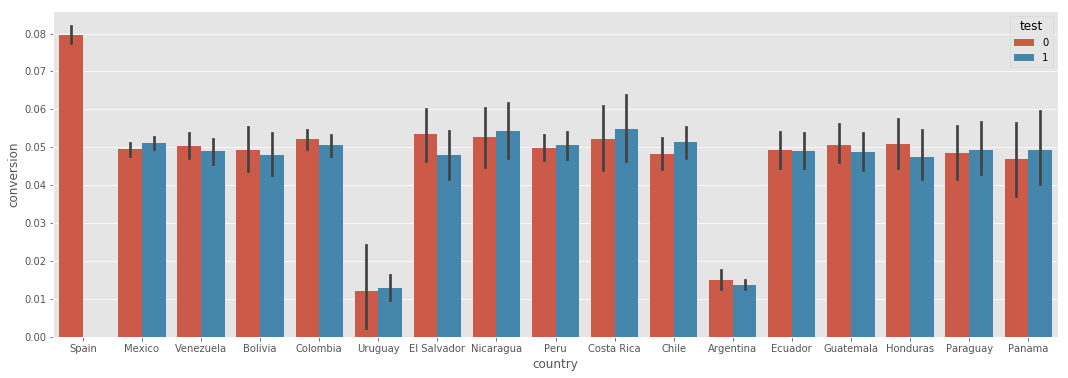

In [24]:
# Visualization
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='country', y='conversion', hue='test', data=data, ax=ax)
plt.show()

From the barplot above, it seems that the control groups perform worse. We need some statistal methods to prove it.

In [25]:
# A/B test
test_data = data[data['country'] != 'Spain']
test_val = test_data[test_data['test'] == 1]['conversion'].values
cont_val = test_data[test_data['test'] == 0]['conversion'].values

In [26]:
print(test_val.mean(), '\t', cont_val.mean())

0.043424713982118966 	 0.04833042316066309


In [27]:
# Welch Two Sample t-test
print(ttest_ind(test_val, cont_val, equal_var=False))

Ttest_indResult(statistic=-7.3939374121344805, pvalue=1.4282994754055316e-13)


## 2. Explain why that might be happening. Are the localized translations really worse?


Likely, there is for some reason some segment of users more likely to end up in test or in control, this segment had a significantly above/below conversion rate and this affected the overall results.

In [73]:
data = data[data['country'] != 'Spain']

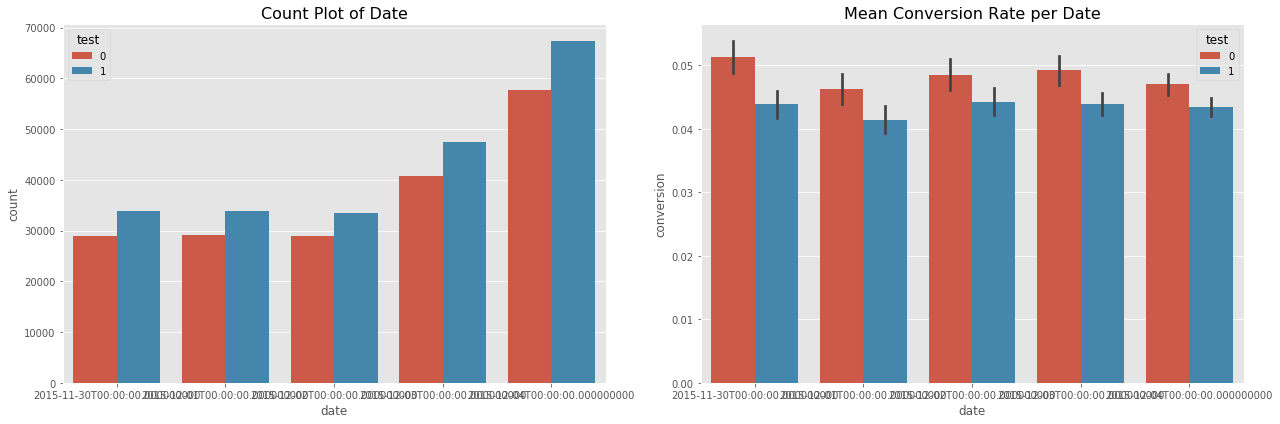

In [76]:
# Visualization of different dates
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='date', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Date', fontsize=16)

sns.barplot(x='date', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Date', fontsize=16)
plt.tight_layout()
plt.show()

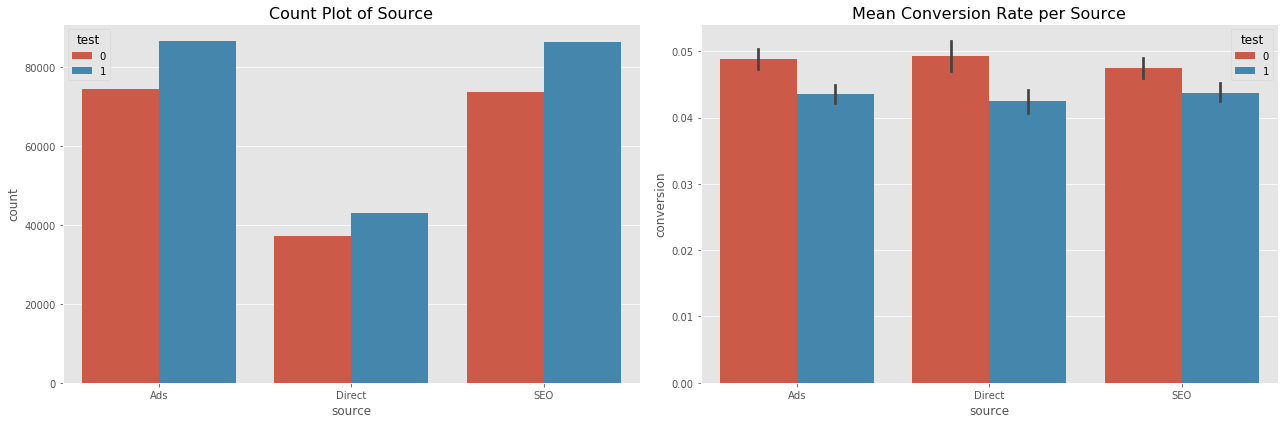

In [39]:
# Visualization of different source
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Source', fontsize=16)

sns.barplot(x='source', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Source', fontsize=16)
plt.tight_layout()
plt.show()

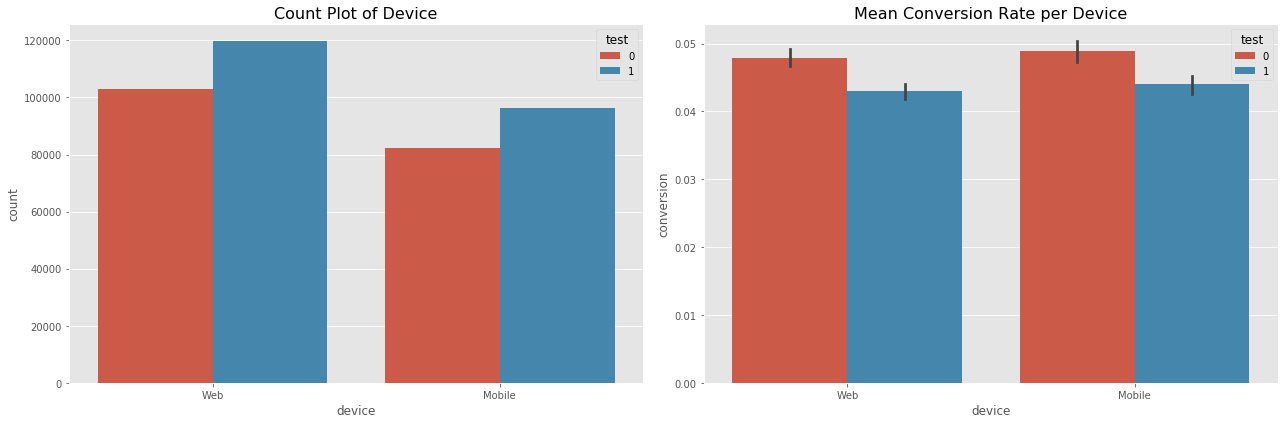

In [40]:
# Visualization of different devices
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='device', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Device', fontsize=16)

sns.barplot(x='device', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Device', fontsize=16)
plt.tight_layout()
plt.show()

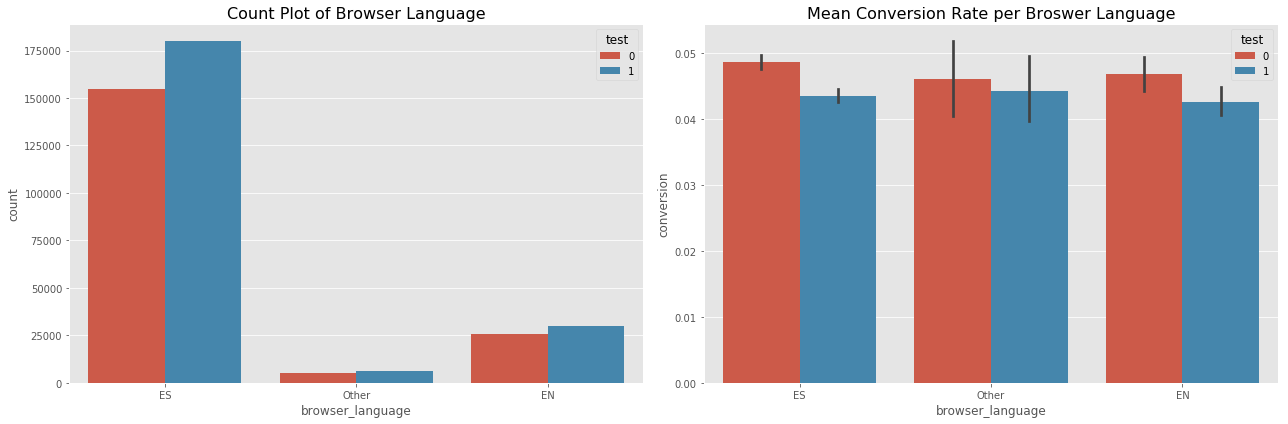

In [41]:
# Visualization of different language
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='browser_language', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Browser Language', fontsize=16)

sns.barplot(x='browser_language', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Broswer Language', fontsize=16)
plt.tight_layout()
plt.show()

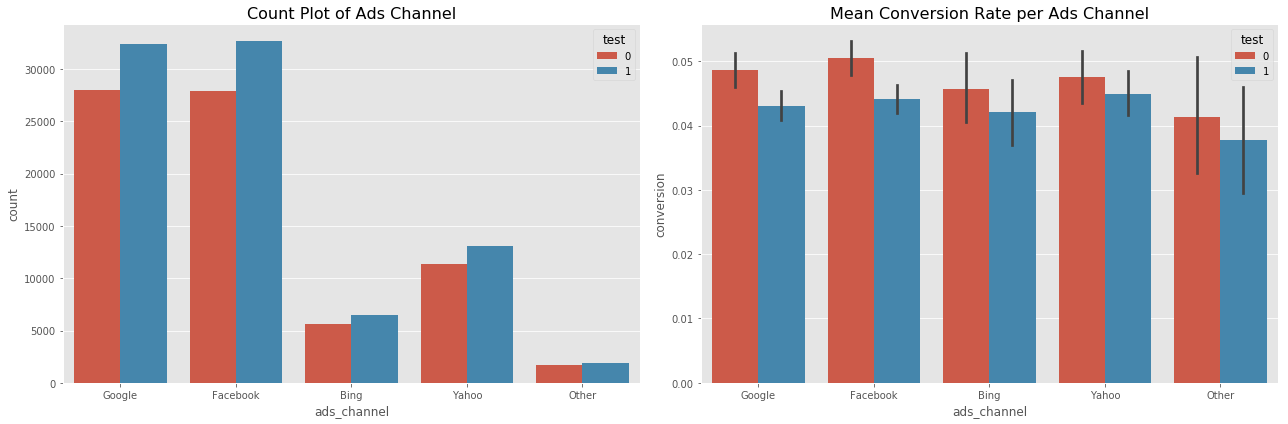

In [42]:
# Visualization of different ad channel
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='ads_channel', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Ads Channel', fontsize=16)

sns.barplot(x='ads_channel', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Ads Channel', fontsize=16)
plt.tight_layout()
plt.show()

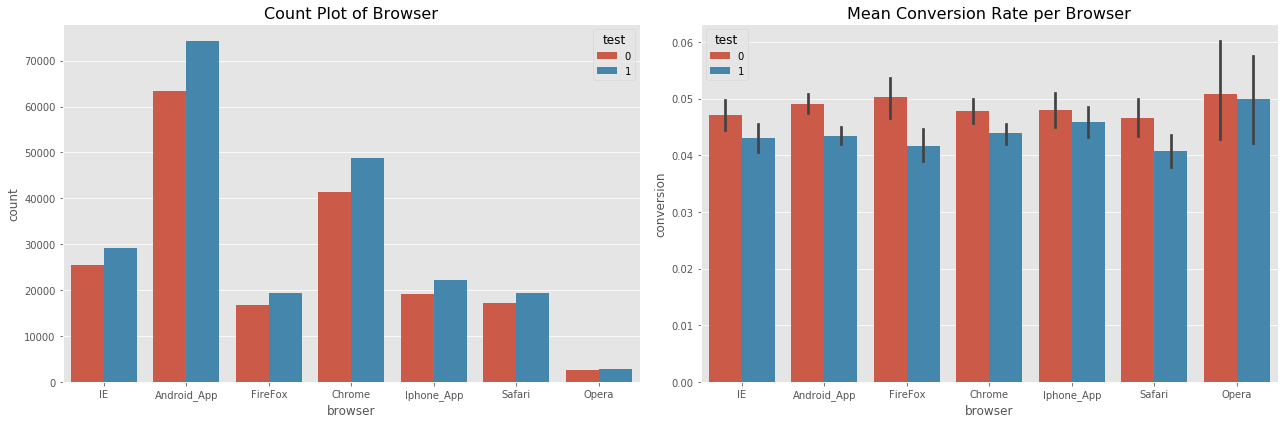

In [43]:
# Visualization of different browsers
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='browser', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Browser', fontsize=16)

sns.barplot(x='browser', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Browser', fontsize=16)
plt.tight_layout()
plt.show()

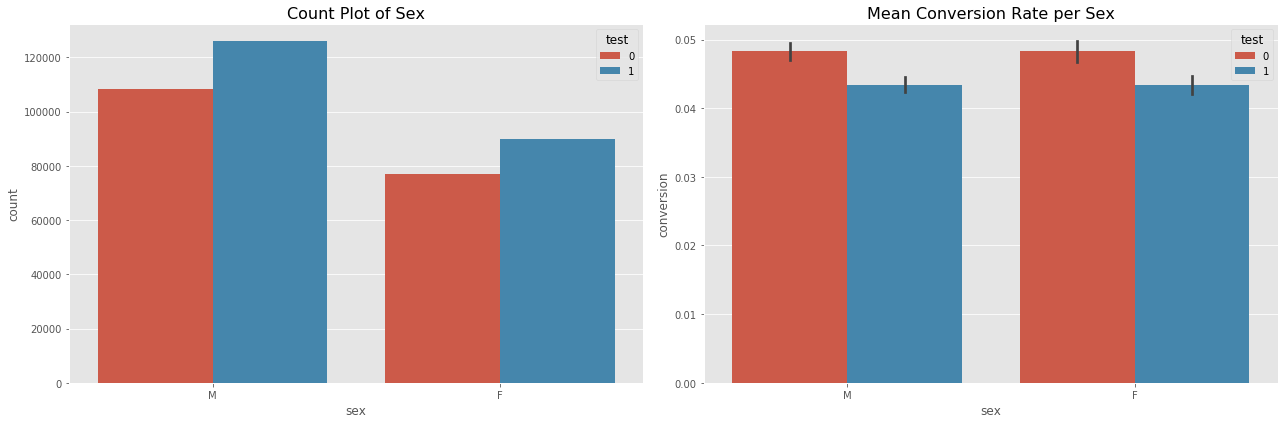

In [44]:
# Visualization of different gender
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='sex', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Sex', fontsize=16)

sns.barplot(x='sex', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Sex', fontsize=16)
plt.tight_layout()
plt.show()

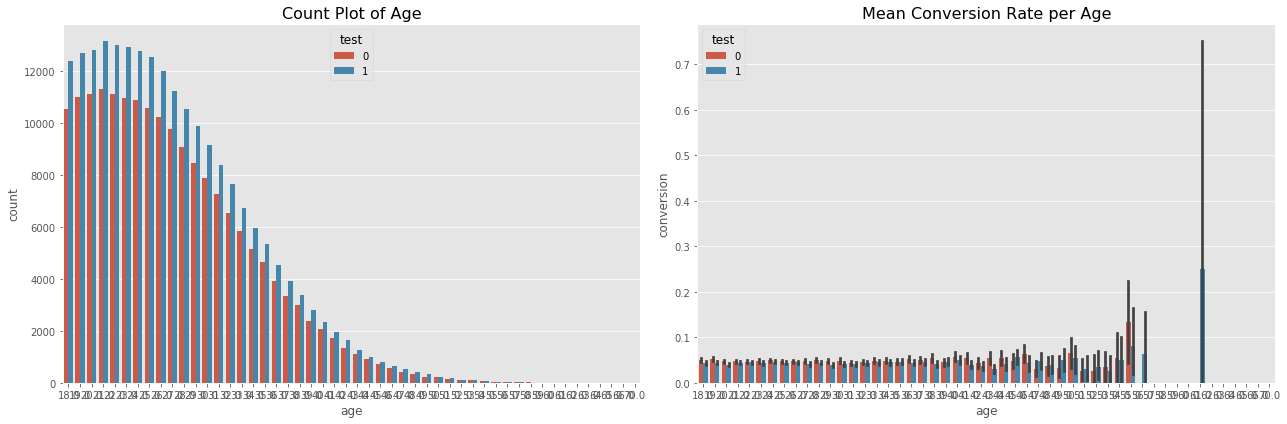

In [47]:
# Visualization of different age
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='age', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Age', fontsize=16)

sns.barplot(x='age', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Age', fontsize=16)
plt.tight_layout()
plt.show()


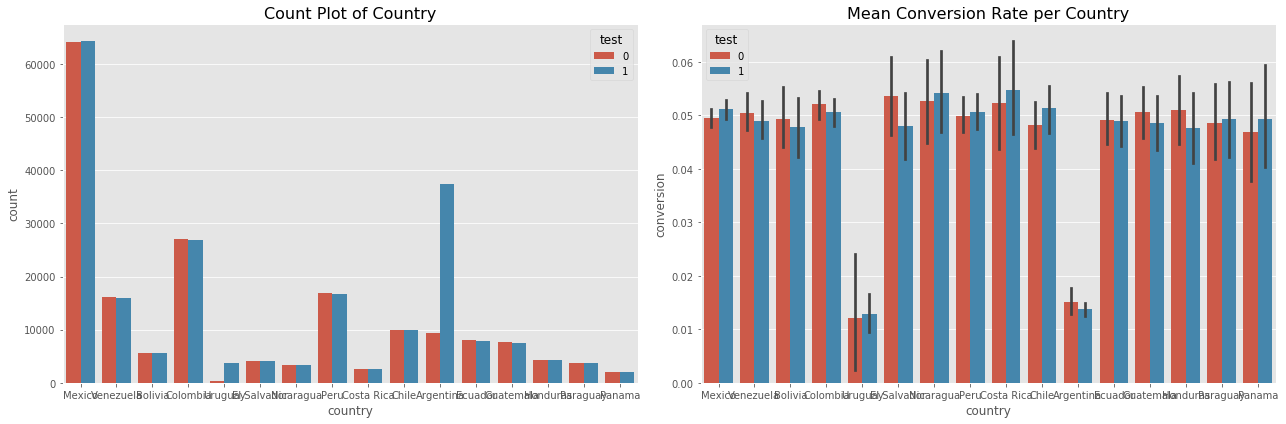

In [48]:
# Visualization of different country
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)

sns.barplot(x='country', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
plt.tight_layout()
plt.show()

### We can see that, except for country, all test groups perform worse. So take a closer look at country.


In an ideal world, the distribution of people in test and control for each segment should be the same. There are many ways to       this. One way is to build a decision tree where the variables are the user dimensions and the outcome variable is whether the user is in test or control. If the tree splits, it means that for given values of that variable you are more likely to end up in test or control.

In [102]:
data = pd.merge(left=test, right=user, how='left', on='user_id' )
data = data[data['country'] != 'Spain']

In [113]:
import h2o
from h2o.frame import H2OFrame
from h2o.estimators import H2OGradientBoostingEstimator

In [108]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

h2o_df = H2OFrame(data)
h2o_df['test'] = h2o_df['test'].asfactor()
h2o_df['ads_channel'] = h2o_df['ads_channel'].asfactor()
h2o_df.summary()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,27 days 0 hours 8 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.3
H2O cluster version age:,1 month and 24 days
H2O cluster name:,H2O_from_python_luyao_mfrbb4
H2O cluster total nodes:,1
H2O cluster free memory:,1.608 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
type,int,time,enum,enum,enum,enum,enum,int,enum,enum,int,enum
mins,1.0,1448841600000.0,,,,,,0.0,,,18.0,
mean,499889.0781244147,1449046579636.8518,,,,,,0.04569170117971106,,,27.128149893414037,
maxs,1000000.0,1449187200000.0,,,,,,1.0,,,70.0,
sigma,288708.31795337563,125496796.59789945,,,,,,0.208815895504632,,,6.774760413689504,
zeros,0,0,,,,,,383192,,,0,
missing,0,0,0,0,0,0,0,0,0,0,454,0
0,497851.0,2015-12-04 00:00:00,Ads,Web,ES,0,IE,0.0,1,M,21.0,Mexico
1,290051.0,2015-12-03 00:00:00,Ads,Mobile,Other,1,Android_App,0.0,1,F,22.0,Mexico
2,548435.0,2015-11-30 00:00:00,Ads,Web,ES,0,FireFox,0.0,1,M,19.0,Mexico


In [110]:
feature = ['user_id', 'date', 'source', 'device', 'browser_language',
       'ads_channel', 'browser', 'sex', 'age',
       'country']
target = 'test'

In [114]:
# Build random forest model
model = H2OGradientBoostingEstimator(ntrees = 2, max_depth = 2)
model.train(x=feature, y=target, training_frame=h2o_df)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [129]:
print(model)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1559673801301_326


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.24491029334582834
RMSE: 0.4948841211292077
LogLoss: 0.6828506675678578
Mean Per-Class Error: 0.4311918615796265
AUC: 0.5707957958344152
pr_auc: 0.6567622518302756
Gini: 0.1415915916688304
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5178860424703127: 


,0,1,Error,Rate
0,31.0,185525.0,0.9998,(185525.0/185556.0)
1,16.0,215967.0,0.0001,(16.0/215983.0)
Total,47.0,401492.0,0.4621,(185541.0/401539.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5178860,0.6995166,4.0
max f2,0.5174320,0.8533700,5.0
max f0point5,0.5301836,0.5926951,3.0
max accuracy,0.5306366,0.5407868,2.0
max precision,0.6060161,0.8996130,0.0
max recall,0.5174320,1.0,5.0
max specificity,0.6060161,0.9977635,0.0
max absolute_mcc,0.5873741,0.2062759,1.0
max min_per_class_accuracy,0.5306366,0.3999817,2.0
max mean_per_class_accuracy,0.5873741,0.5688081,1.0


Gains/Lift Table: Avg response rate: 53.79 %, avg score: 53.78 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0102954,0.6060161,1.6724913,1.6724913,0.8996130,0.6060161,0.8996130,0.6060161,0.0172189,0.0172189,67.2491310,67.2491310
,2,0.1266801,0.5873741,1.4869246,1.5020057,0.7997989,0.5873741,0.8079108,0.5888891,0.1730553,0.1902742,48.6924588,50.2005738
,3,0.6332262,0.5306366,0.9307772,1.0450544,0.5006539,0.5306366,0.5621222,0.5422903,0.4714816,0.6617558,-6.9222751,4.5054399
,4,0.9997186,0.5301836,0.9223922,1.0000870,0.4961437,0.5301836,0.5379348,0.5378520,0.3380498,0.9998055,-7.7607789,0.0086982
,5,1.0,0.5174320,0.6910015,1.0,0.3716814,0.5176972,0.5378880,0.5378464,0.0001945,1.0,-30.8998467,0.0



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-07-01 12:05:49,0.004 sec,0.0,0.4985624,0.6902734,0.5,0.0,1.0,0.4621120
,2019-07-01 12:05:49,0.523 sec,1.0,0.4965328,0.6861928,0.5691115,0.6926047,1.6724913,0.4621120
,2019-07-01 12:05:50,0.752 sec,2.0,0.4948841,0.6828507,0.5707958,0.6567623,1.6724913,0.4620747


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
country,7758.7045898,1.0,0.9995396
age,1.8242611,0.0002351,0.0002350
browser,1.7491521,0.0002254,0.0002253
user_id,0.0,0.0,0.0
date,0.0,0.0,0.0
source,0.0,0.0,0.0
device,0.0,0.0,0.0
browser_language,0.0,0.0,0.0
ads_channel,0.0,0.0,0.0
sex,0.0,0.0,0.0


In [132]:
data.groupby(['country','test']).size()

country      test
Argentina    0        9356
             1       37377
Bolivia      0        5550
             1        5574
Chile        0        9853
             1        9884
Colombia     0       27088
             1       26972
Costa Rica   0        2660
             1        2649
Ecuador      0        8036
             1        7859
El Salvador  0        4108
             1        4067
Guatemala    0        7622
             1        7503
Honduras     0        4361
             1        4207
Mexico       0       64209
             1       64275
Nicaragua    0        3419
             1        3304
Panama       0        1966
             1        1985
Paraguay     0        3650
             1        3697
Peru         0       16869
             1       16797
Uruguay      0         415
             1        3719
Venezuela    0       16149
             1       15905
missing      0         245
             1         209
dtype: int64

 Argentina and Uruguay together have 80% test and 20% control!
  Not a great success given that the goal was to improve conversion rate, but at least we know that a localized translation didn’t make things worse!

In [133]:
countries = [name for name in data['country'].unique() if name is not np.nan]

for country in countries:
    test_val = data[(data['country'] == country) & (data['test'] == 1)]['conversion'].values
    cont_val = data[(data['country'] == country) & (data['test'] == 0)]['conversion'].values
    
    test_mean = test_val.mean()
    cont_mean = cont_val.mean()
    p_val = ttest_ind(test_val, cont_val, equal_var=False).pvalue
    
    print('{0:15s} {1:15.5f} {2:15.5f} {3:10f}'.format(country, test_mean, cont_mean, p_val))

Mexico                  0.05119         0.04949   0.165544
Venezuela               0.04898         0.05034   0.573702
Bolivia                 0.04790         0.04937   0.718885
Colombia                0.05057         0.05209   0.423719
Uruguay                 0.01291         0.01205   0.879764
El Salvador             0.04795         0.05355   0.248127
Nicaragua               0.05418         0.05265   0.780400
Peru                    0.05060         0.04991   0.771953
Costa Rica              0.05474         0.05226   0.687876
Chile                   0.05130         0.04811   0.302848
Argentina               0.01373         0.01507   0.335147
Ecuador                 0.04899         0.04915   0.961512
Guatemala               0.04865         0.05064   0.572107
Honduras                0.04754         0.05091   0.471463
Paraguay                0.04923         0.04849   0.883697
Panama                  0.04937         0.04680   0.705327
missing                 0.05742         0.07755   0.3924